# Implementing the NFFT

In [1]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

We want to solve the following:

$$
\hat{f}_k = \sum_{j=0}^{M-1} f_j e^{2\pi i k x_j}, 
$$

for complex $\{f_j\}$ at points $\{x_j\}$ satisfying $-1/2 \le x_j < 1/2$,
and for integer wavenumbers $k$ in the range -N/2 \le k < N.

A straightforward implementation of this sum would require $\mathcal{O}[MN]$ operations, but the nonequispaced fast Fourier transform (NFFT) allows this to be computed in $\mathcal{O}[M\log N]$.
In this post, we'll work on writing a pure Python implementation of this NFFT algorithm.

## Straightforward implementation

As our first step, we'll define a simple reference implementation of the nonuniform direct Fourier transform (*NDFT*):

In [2]:
def ndft(x, f, N):
    """nonuniform discrete Fourier transform"""
    k = -(N // 2) + np.arange(N)
    return np.dot(f, np.exp(2j * np.pi * k * x[:, np.newaxis]))

Let's try evaluating this on some sinusoidal data, with a frequency of 10 cycles per unit time:

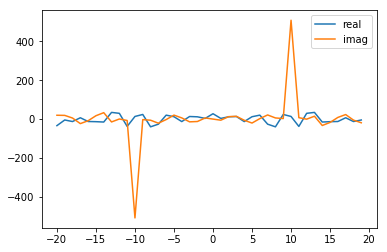

In [3]:
x = -0.5 + np.random.rand(1000)
f = np.sin(10 * 2 * np.pi * x)

k = -20 + np.arange(40)
f_k = ndft(x, f, len(k))

plt.plot(k, f_k.real, label='real')
plt.plot(k, f_k.imag, label='imag')
plt.legend()

As expected, the NFFT shows strong features at wave numbers $\pm 10$.

## Fast transform: initial implementation

### The Kernel function

In [4]:
# equations C.1 from https://www-user.tu-chemnitz.de/~potts/paper/nfft3.pdf

def phi(x, n, m, sigma):
    b = (2 * sigma * m) / ((2 * sigma - 1) * np.pi)
    return np.exp(-(n * x) ** 2 / b) / np.sqrt(np.pi * b)

def phi_hat(k, n, m, sigma):
    b = (2 * sigma * m) / ((2 * sigma - 1) * np.pi)
    return np.exp(-b * (np.pi * k / n) ** 2)

In [5]:
from numpy.fft import fft, fftshift, ifftshift

N = 1000
sigma = 1
n = N * sigma
m = 20

# compute phi(x)
x = np.linspace(-0.5, 0.5, N, endpoint=False)
f = phi(x, n, m, sigma)

# compute phi_hat(k)
k = -(N // 2) + np.arange(N)
f_hat = phi_hat(k, n, m, sigma)

# compute the FFT of phi(x)
f_fft = fftshift(fft(ifftshift(f)))

# assure they match
np.allclose(f_fft, f_hat)

True

### The expanded algorithm

In [6]:
import numpy as np


def nfft1(x, f, N, sigma=2):
    """Alg 3 from https://www-user.tu-chemnitz.de/~potts/paper/nfft3.pdf"""
    n = N * sigma  # size of oversampled grid
    m = 20  # magic number: we'll set this more carefully later
    
    # 1. Express f(x) in terms of basis functions phi
    shift_to_range = lambda x: -0.5 + (x + 0.5) % 1
    x_grid = np.linspace(-0.5, 0.5, n, endpoint=False)
    g = np.dot(f, phi(shift_to_range(x[:, None] - x_grid), n, m, sigma))
    
    # 2. Compute the Fourier transform of g on the oversampled grid
    k = -(N // 2) + np.arange(N)
    g_k = np.dot(g, np.exp(2j * np.pi * k * x_grid[:, None]))
    
    # 3. Divide by the Fourier transform of the convolution kernel
    f_k = g_k / phi_hat(k, n, m, sigma)
    
    return f_k

In [7]:
x = -0.5 + np.random.rand(1000)
f = np.sin(10 * 2 * np.pi * x)
N = 100

np.allclose(ndft(x, f, N),
            nfft1(x, f, N))

True

## Speedup #1: using an FFT

We'll replace this slow sum

``` python
g_k = np.dot(g, np.exp(2j * np.pi * k * x_grid[:, None]))
```

With the FFT-based version of the sum

``` python
g_k_n = fftshift(ifft(ifftshift(g)))
g_k = n * g_k_n[(n - N) // 2: (n + N) // 2]
```

In [8]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift


def nfft2(x, f, N, sigma=2):
    """Alg 3 from https://www-user.tu-chemnitz.de/~potts/paper/nfft3.pdf"""
    n = N * sigma  # size of oversampled grid
    m = 20  # magic number: we'll set this more carefully later
    
    # 1. Express f(x) in terms of basis functions phi
    shift_to_range = lambda x: -0.5 + (x + 0.5) % 1
    x_grid = np.linspace(-0.5, 0.5, n, endpoint=False)
    g = np.dot(f, phi(shift_to_range(x[:, None] - x_grid), n, m, sigma))
    
    # 2. Compute the Fourier transform of g on the oversampled grid
    k = -(N // 2) + np.arange(N)
    g_k_n = fftshift(ifft(ifftshift(g)))
    g_k = n * g_k_n[(n - N) // 2: (n + N) // 2]
    
    # 3. Divide by the Fourier transform of the convolution kernel
    f_k = g_k / phi_hat(k, n, m, sigma)
    
    return f_k

In [9]:
x = -0.5 + np.random.rand(1000)
f = np.sin(10 * 2 * np.pi * x)
N = 100

np.allclose(ndft(x, f, N),
            nfft2(x, f, N))

True

## Speedup #2: Truncating the basis function sum

The expression of the inputs in terms of the basis functions $\phi$ takes the form of a matrix-vector product:

``` python
np.dot(f, phi(shift_to_range(x[:, None] - x_grid), n, m, sigma))
```

The NFFT algorithm is designed so that this matrix will be sparse, as we can see by visualizing it:

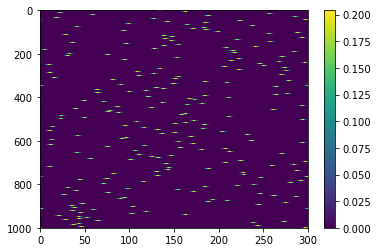

In [10]:
sigma = 3
n = sigma * N
m = 20
x_grid = np.linspace(-0.5, 0.5, n, endpoint=False)
shift_to_range = lambda x: -0.5 + (x + 0.5) % 1

mat = phi(shift_to_range(x[:, None] - x_grid), n, m, sigma)
plt.imshow(mat, aspect='auto')
plt.colorbar()

By design, each row of the matrix contains just a single nonzero clump of entries, of width approximately $2m$.
We could make this basis function sum *far* more efficient if we construct this as a sparse rather than a dense matrix.
Because each row has the same number of nonzero entries (that is, $2m$), this can be done quite efficiently using scipy's compressed sparse row (CSR) sparse matrix format.
We will build the matrix from an array of values, an array of column indices, and an array of indices specifying the beginning and end of each sequential row within these arrays:

True

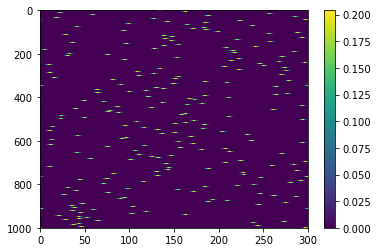

In [11]:
from scipy.sparse import csr_matrix

col_ind = np.floor(n * x[:, np.newaxis]).astype(int) + np.arange(-m, m)
vals = phi(shift_to_range(x[:, None] - col_ind / n), n, m, sigma)
col_ind = (col_ind + n // 2) % n
row_ptr = np.arange(len(x) + 1) * col_ind.shape[1]
spmat = csr_matrix((vals.ravel(), col_ind.ravel(), row_ptr), shape=(len(x), n))

plt.imshow(spmat.toarray(), aspect='auto')
plt.colorbar()
np.allclose(spmat.toarray(), mat)

In [12]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift


def nfft3(x, f, N, sigma=2):
    """Alg 3 from https://www-user.tu-chemnitz.de/~potts/paper/nfft3.pdf"""
    n = N * sigma  # size of oversampled grid
    m = 20  # magic number: we'll set this more carefully later
    
    # 1. Express f(x) in terms of basis functions phi
    shift_to_range = lambda x: -0.5 + (x + 0.5) % 1
    col_ind = np.floor(n * x[:, np.newaxis]).astype(int) + np.arange(-m, m)
    vals = phi(shift_to_range(x[:, None] - col_ind / n), n, m, sigma)
    col_ind = (col_ind + n // 2) % n
    row_ptr = np.arange(len(x) + 1) * col_ind.shape[1]
    mat = csr_matrix((vals.ravel(), col_ind.ravel(), row_ptr), shape=(len(x), n))
    g = mat.T.dot(f)
    
    # 2. Compute the Fourier transform of g on the oversampled grid
    k = -(N // 2) + np.arange(N)
    g_k_n = fftshift(ifft(ifftshift(g)))
    g_k = n * g_k_n[(n - N) // 2: (n + N) // 2]
        
    # 3. Divide by the Fourier transform of the convolution kernel
    f_k = g_k / phi_hat(k, n, m, sigma)
    
    return f_k

In [13]:
x = -0.5 + np.random.rand(1000)
f = np.sin(10 * 2 * np.pi * x)
N = 100

np.allclose(ndft(x, f, N),
            nfft3(x, f, N))

True

## Choosing ``m``

Finally, we should be a bit more careful about choosing a suitable value of ``m`` for our problem.
The paper offers a way to estimate ``m`` from a desired error tolerance for the result of the computation.

In [14]:
def C_phi(m, sigma):
    return 4 * np.exp(-m * np.pi * (1 - 1. / (2 * sigma - 1)))

def m_from_C_phi(C, sigma):
    return np.ceil(-np.log(0.25 * C) / (np.pi * (1 - 1 / (2 * sigma - 1))))

Let's add this to our nfft function

In [15]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift


def nfft(x, f, N, sigma=2, tol=1E-8):
    """Alg 3 from https://www-user.tu-chemnitz.de/~potts/paper/nfft3.pdf"""
    n = N * sigma  # size of oversampled grid
    m = m_from_C_phi(tol / N, sigma)
    
    # 1. Express f(x) in terms of basis functions phi
    shift_to_range = lambda x: -0.5 + (x + 0.5) % 1
    col_ind = np.floor(n * x[:, np.newaxis]).astype(int) + np.arange(-m, m)
    vals = phi(shift_to_range(x[:, None] - col_ind / n), n, m, sigma)
    col_ind = (col_ind + n // 2) % n
    indptr = np.arange(len(x) + 1) * col_ind.shape[1]
    mat = csr_matrix((vals.ravel(), col_ind.ravel(), indptr), shape=(len(x), n))
    g = mat.T.dot(f)
    
    # 2. Compute the Fourier transform of g on the oversampled grid
    k = -(N // 2) + np.arange(N)
    g_k_n = fftshift(ifft(ifftshift(g)))
    g_k = n * g_k_n[(n - N) // 2: (n + N) // 2]
    
    # 3. Divide by the Fourier transform of the convolution kernel
    f_k = g_k / phi_hat(k, n, m, sigma)
    
    return f_k

In [16]:
x = -0.5 + np.random.rand(1000)
f = np.sin(10 * 2 * np.pi * x)
N = 100

np.allclose(ndft(x, f, N),
            nfft(x, f, N))

True

In [17]:
from pynfft import NFFT

def cnfft(x, f, N):
    """Compute the nfft with pynfft"""
    plan = NFFT(N, len(x))
    plan.x = x
    plan.precompute()
    plan.f = f
    # need to return a copy because of a
    # reference counting bug in pynfft
    return plan.adjoint().copy()

In [18]:
np.allclose(cnfft(x, f, N),
            nfft(x, f, N))

True

In [19]:
x = -0.5 + np.random.rand(1000)
f = np.sin(10 * 2 * np.pi * x)
N = 10000

print("direct ndft:")
%timeit ndft(x, f, N)
print()
print("fast nfft:")
%timeit nfft(x, f, N)
print()
print("wrapped C-nfft/pynfft package:")
%timeit cnfft(x, f, N)

direct ndft:
1 loop, best of 3: 499 ms per loop

fast nfft:
100 loops, best of 3: 2.95 ms per loop

wrapped C-nfft/pynfft package:
100 loops, best of 3: 7.86 ms per loop
